In [1]:
# Standard library imports
import json
import sys

# Third-party library imports
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Local application imports
from utils import fetch_api_data, load_config, write_to_csv

## Fetch and process data from the NOAA's Severe Weather Data Inventory (SWDI) API. 

### Key Components:

- **Datasets**: Currently, only the `nx3tvs` dataset is specified, which corresponds to NEXRAD Level-3 Tornado Vortex Signatures.
- **Output Format**: Data is requested in JSON format (`outputFormat = "json"`).
- **Date Range**: The data is queried for the period from July 1, 2024, to July 31, 2024 (`daterange = "20240701:20240731"`).

### Process:
1. **URL Construction**: A base URL is created for each dataset using the format `https://www.ncdc.noaa.gov/swdiws/{outputFormat}/{dataset}/{daterange}`.
2. **Data Fetching**: The `fetch_api_data()` function is used to retrieve data from the constructed URL.
3. **Data Handling**:
   - If data is successfully fetched and contains results, it is written to a CSV file named `swdiws_{dataset}.csv`.
   - If no data is found or the response format is invalid, an error message is printed.

For more information about the datasets and their definitions, visit [NOAA SWDI](https://www.ncdc.noaa.gov/swdiws).

In [2]:
### Available datasets ###
# 'nx3tvs'       - (Point)   NEXRAD Level-3 Tornado Vortex Signatures
# 'nx3meso'      - (Point)   NEXRAD Level-3 Mesocyclone Signatures
# 'nx3hail'      - (Point)   NEXRAD Level-3 Hail Signatures
# 'nx3structure' - (Point)   NEXRAD Level-3 Storm Cell Structure Information
# 'warn'         - (Polygon) Severe Thunderstorm, Tornado, Flash Flood and Special Marine warnings
#
# ':inv' may be added to any dataset name to display the inventory of available data for that dataset.  For example 'nx3tvs:inv'.

### Output formats ###
# 'json' - JSON is commonly used in web application development and is widely supported by many programming languages.
# 'csv' - Comma-separated plain text which can be opened in MS Excel, OpenOffice, ArcGIS, etc...
# 'xml' - XML which can be opened in MS Excel, OpenOffice, etc...
# 'shp' - A .zip file containing the 4 ESRI Shapefile files (.shp, .shx, .dbf, .prj)
# 'kmz' - KMZ file which can be opened in Virtual Globe software such as Google Earth

# Define the list of datasets to fetch
datasets = ["nx3tvs"]  # NEXRAD Level-3 Tornado Vortex Signatures

# Specify the desired output format for the data
outputFormat = "geojson"  # Data will be fetched in GEOJSON format

# Define the date range for the data query
daterange = "20240701:20240731"  # Data for July 2024

# Define the number of results to return
numResults = 2500

# Initialize an empty list to store merged data
merged_data_list = []

for dataset in datasets:
    base_url = f"https://www.ncdc.noaa.gov/swdiws/{outputFormat}/{dataset}/{daterange}/{numResults}"
    filename = f"swdiws_{dataset}_{outputFormat}.csv"

    data = fetch_api_data(base_url)
    # Data is nested, retrieve "features" dictionary
    rows = data["features"]
    
    # Iterate over each record in rows as that is nested as well
    for record in rows:
       # Merge the 'properties' and 'geometry' dictionaries
        merged_data = {**record["properties"], **record["geometry"]}
        # Append the merged data to the list
        merged_data_list.append(merged_data)

    # Convert to DataFrame
    swdiws_tornado_data_df = pd.DataFrame(merged_data_list)

# Split the coordinates column into latitude and longitude
swdiws_tornado_data_df[['longitude', 'latitude']] = pd.DataFrame(swdiws_tornado_data_df['coordinates'].tolist(), index=swdiws_tornado_data_df.index)
# Drop the original coordinates column
swdiws_tornado_data_df = swdiws_tornado_data_df.drop(columns=['coordinates'])

if data and "features" in data:
    write_to_csv(data["features"], filename, "w")
else:
    print(f"No data found or invalid response format for dataset: {dataset}")

# Convert 'MXDV' to numeric, forcing errors to NaN if conversion fails
swdiws_tornado_data_df['MXDV'] = pd.to_numeric(swdiws_tornado_data_df['MXDV'], errors='coerce')
# Ensure 'WSR_ID' is treated as a string
swdiws_tornado_data_df['WSR_ID'] = swdiws_tornado_data_df['WSR_ID'].astype(str)
# Save the DataFrame to a CSV file
swdiws_tornado_data_df.to_csv('swdiws_nx3tvs_geojson.csv', index=False)

swdiws_tornado_data_df.head()

,CELL_TYPE,MAX_SHEAR,WSR_ID,MXDV,CELL_ID,ZTIME,AZIMUTH,RANGE,type,longitude,latitude
0,TVS,30,KIAD,76,X1,2024-07-01T00:03:15Z,135,40,Point,-76.9275,38.6106
1,TVS,41,KBWI,90,N4,2024-07-01T00:05:01Z,204,35,Point,-76.9325,38.5563
2,TVS,50,KDCA,78,R3,2024-07-01T00:07:32Z,102,25,Point,-76.4415,38.6711
3,TVS,37,KDEN,81,Q7,2024-07-01T00:11:04Z,118,35,Point,-103.8610,39.4510
4,TVS,44,KDEN,90,U4,2024-07-01T00:14:14Z,119,34,Point,-103.8861,39.4503


## Fetch and process data on tornado-related disaster declarations from FEMA's OpenFEMA API.

### Key Steps:
1. **API Request**:
   - Constructs the API request URL for the `DisasterDeclarationsSummaries` endpoint at `https://www.fema.gov/api/open/v2/`.
   - Filters the data to include only incidents where `incidentType` is 'Tornado'.

2. **Data Retrieval and Saving**:
   - Fetches data from the API.
   - Converts the data into a DataFrame.
   - Saves the DataFrame to a CSV file named `DisasterDeclarationsSummaries.csv`.

For more details on FEMA datasets, visit [OpenFEMA Data Sets](https://www.fema.gov/about/openfema/data-sets).

In [3]:
# Base URL for FEMA's OpenFEMA API
base_url = f"https://www.fema.gov/api/open/v2/"

# Parameters for the API request:
# - $count: To get the count of records matching the filter
# - $filter: Filters the data to include only 'Tornado' incidents
params = {"$count": "true",
          "$filter": "incidentType eq 'Tornado'"}

# Endpoint for the API request
endpoint = "DisasterDeclarationsSummaries"
# Filename to save the data
filename = f"{endpoint}.csv"
# Construct the full URL for the API request
endpoint_url = f"{base_url}{endpoint}"

# Fetch data from the API
data = fetch_api_data(endpoint_url, params)

# Convert the fetched data to a DataFrame
disaster_declarations_df = pd.DataFrame(data["DisasterDeclarationsSummaries"])

# Save the DataFrame to a CSV file
write_to_csv(data["DisasterDeclarationsSummaries"], filename, "w")

disaster_declarations_df.head()

,femaDeclarationString,disasterNumber,state,declarationType,declarationDate,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,...,tribalRequest,fipsStateCode,fipsCountyCode,placeCode,designatedArea,declarationRequestNumber,lastIAFilingDate,lastRefresh,hash,id
0,DR-4706-OK,4706,OK,DR,2023-04-24T00:00:00.000Z,2023,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",True,False,...,False,40,027,99027,Cleveland (County),23044,2023-06-23T00:00:00.000Z,2023-05-22T03:41:22.800Z,a2b96bd89ea440c5fa2961babf06511a8fa43e63,4a7e77b6-d5ab-4094-99a8-79172066f9a4
1,DR-4706-OK,4706,OK,DR,2023-04-24T00:00:00.000Z,2023,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",True,False,...,False,40,087,99087,McClain (County),23044,2023-06-23T00:00:00.000Z,2023-05-22T03:41:22.800Z,45fd8632371d22b3bdd57496043fa7b8e92c9368,0a01ff9c-a228-4ff7-b950-979735dba876
2,DR-4706-OK,4706,OK,DR,2023-04-24T00:00:00.000Z,2023,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",True,False,...,False,40,125,99125,Pottawatomie (County),23044,2023-06-23T00:00:00.000Z,2023-05-22T03:41:22.800Z,d0a2570a6d504ae4297ab23a07710af5a65f6d51,93cb7460-c67b-4c71-9fa0-60541bae64a6
3,DR-4637-TN,4637,TN,DR,2022-01-14T00:00:00.000Z,2022,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",False,False,...,False,47,039,99039,Decatur (County),21130,2022-03-15T00:00:00.000Z,2023-05-22T03:41:22.800Z,3804065dcfd26fa0a8e0cb808d1bf8a1ea04fbc7,1b7ae183-1726-44b7-bafb-1c95b3dce221
4,DR-4637-TN,4637,TN,DR,2022-01-14T00:00:00.000Z,2022,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",False,False,...,False,47,045,99045,Dyer (County),21130,2022-03-15T00:00:00.000Z,2023-05-22T03:41:22.800Z,c6856f8aba8c932c99a1c8e4f7aba07794d31f6a,30008315-849b-4143-b322-148b1d9039db


## Fetch and process data on housing assistance owners related to previously identified tornado disaster declarations from FEMA's OpenFEMA API.

### Key Steps:
1. **Extract and Format Disaster Numbers**:
   - Retrieves unique disaster numbers from the `disaster_declarations_df` DataFrame.
   - Formats these numbers into a comma-separated string for use in the API request.

2. **API Request**:
   - Constructs parameters to filter the data by the formatted disaster numbers.
   - Defines the endpoint for fetching housing assistance records.

3. **Data Retrieval and Saving**:
   - Fetches data from the API.
   - Converts the data into a DataFrame.
   - Saves the DataFrame to a CSV file named `HousingAssistanceOwners.csv`.

In [4]:
# Extract unique disaster numbers from the disaster_declarations_df DataFrame
disaster_numbers = disaster_declarations_df.disasterNumber.unique()
# Format the disaster numbers into a comma-separated string for use in the API filter
formatted_disaster_numbers = ', '.join(f'{num}' for num in disaster_numbers)

# Define parameters for the API request:
# - $count: To get the count of records matching the filter
# - $filter: Filters the data to include only records with disaster numbers from the formatted list
params = {"$count": "true",
          "$filter": f"disasterNumber in ({formatted_disaster_numbers})"}

# Endpoint for the API request
endpoint = "HousingAssistanceOwners"
# Filename to save the data
filename = f"{endpoint}.csv"
# Construct the full URL for the API request
endpoint_url = f"{base_url}{endpoint}"

# Fetch data from the API
data = fetch_api_data(endpoint_url, params)

# Convert the fetched data to a DataFrame
housing_assistance_df = pd.DataFrame(data["HousingAssistanceOwners"])

# Save the DataFrame to a CSV file
write_to_csv(data["HousingAssistanceOwners"], filename, "w")

housing_assistance_df.head()

,disasterNumber,state,county,city,zipCode,validRegistrations,averageFemaInspectedDamage,totalInspected,totalDamage,noFemaInspectedDamage,...,approvedForFemaAssistance,totalApprovedIhpAmount,repairReplaceAmount,rentalAmount,otherNeedsAmount,approvedBetween1And10000,approvedBetween10001And25000,approvedBetween25001AndMax,totalMaxGrants,id
0,1484,OH,Carroll (County),BOWERSTON,44695,1,0.00,1,0.00,1,...,0,0.00,0.00,0.0,0.00,0,0,0,0,f3ce438d-b5ed-4858-ba2b-8d056e19fa39
1,1484,OH,Carroll (County),CARROLLTON,44615,6,949.53,5,5697.17,1,...,2,3376.37,1983.52,0.0,1392.85,2,0,0,0,6a15d3ab-8248-4a0b-b7d2-1d6675dacf23
2,1484,OH,Carroll (County),CLEVELAND,44120,1,0.00,0,0.00,0,...,0,0.00,0.00,0.0,0.00,0,0,0,0,b206a276-de52-4d76-808f-6883a5020388
3,1484,OH,Carroll (County),DELLROY,44620,2,2941.96,2,5883.91,0,...,2,4369.78,4149.35,0.0,220.43,2,0,0,0,e292c428-ba45-480f-8d9f-d22d973a17a7
4,1484,OH,Carroll (County),MALVERN,44644,2,3441.74,2,6883.48,0,...,2,6338.50,6338.50,0.0,0.00,1,1,0,0,dc4a2978-e190-4dcf-b9f8-583e20dc9ee4


In [5]:
# Standardize column names to lowercase
swdiws_tornado_data_df.columns = [col.lower() for col in swdiws_tornado_data_df.columns]

#dropped cell and cell id columns
swdiws_tornado_data_df.drop(columns=['cell_type', 'cell_id',], inplace=True)

#renamed columns 
#max_shear = change in wind speed and direction with height in the atmosphere
#wsr_id = weather stations
#mxdv = maximum difference in velocity, particularly within areas of rotation
#ztime = time of the event
#azimuth = direction in which the tornado is moving
swdiws_tornado_data_df.rename(columns={
    'max_shear': 'wind_speed',
    'wsr_id': 'radar_id',
    'mxdv': 'velocity',
    'ztime': 'event_time',
    'azimuth': 'directional_movement',
}, inplace=True)

# Convert 'ztime' column to datetime
swdiws_tornado_data_df['event_time'] = pd.to_datetime(swdiws_tornado_data_df['event_time'])

# Remove duplicates
swdiws_tornado_data_df.drop_duplicates(inplace=True)

# Display the cleaned dataframe
swdiws_tornado_data_df.head()

,wind_speed,radar_id,velocity,event_time,directional_movement,range,type,longitude,latitude
0,30,KIAD,76,2024-07-01 00:03:15+00:00,135,40,Point,-76.9275,38.6106
1,41,KBWI,90,2024-07-01 00:05:01+00:00,204,35,Point,-76.9325,38.5563
2,50,KDCA,78,2024-07-01 00:07:32+00:00,102,25,Point,-76.4415,38.6711
3,37,KDEN,81,2024-07-01 00:11:04+00:00,118,35,Point,-103.8610,39.4510
4,44,KDEN,90,2024-07-01 00:14:14+00:00,119,34,Point,-103.8861,39.4503


In [6]:
radar_locations_df = pd.read_csv('radar_locations.csv')
radar_locations_merge_df = swdiws_tornado_data_df.merge(radar_locations_df, on='radar_id', how='left')
radar_locations_merge_df.head()

,wind_speed,radar_id,velocity,event_time,directional_movement,range,type,longitude,latitude,city,state
0,30,KIAD,76,2024-07-01 00:03:15+00:00,135,40,Point,-76.9275,38.6106,Washington Dulles International Airport,VA
1,41,KBWI,90,2024-07-01 00:05:01+00:00,204,35,Point,-76.9325,38.5563,Baltimore/Washington International Thurgood Ma...,MD
2,50,KDCA,78,2024-07-01 00:07:32+00:00,102,25,Point,-76.4415,38.6711,Ronald Reagan Washington National Airport,VA
3,37,KDEN,81,2024-07-01 00:11:04+00:00,118,35,Point,-103.8610,39.4510,Denver International Airport,CO
4,44,KDEN,90,2024-07-01 00:14:14+00:00,119,34,Point,-103.8861,39.4503,Denver International Airport,CO


In [7]:
%%capture --no-display

# Configure the map plot
tornadoes_plot = radar_locations_merge_df.hvplot.points(
    "longitude",
    "latitude",
    geo=True,
    tiles="OSM",
    frame_width=800,
    frame_height=600,
    size="velocity",
    color="radar_id",
    hover_cols=['city', 'state']
)

# Display the map
tornadoes_plot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [longitude,latitude]   (radar_id,velocity,city,state)

# Visualization Coding

In [8]:
try:
    # Check if the DataFrame is not empty
    if swdiws_tornado_data_df.empty:
        print("The DataFrame is empty. No data to plot.")
    else:
        # Create a base map centered around the mean latitude and longitude
        base_map = folium.Map(location=[swdiws_tornado_data_df['latitude'].mean(), swdiws_tornado_data_df['longitude'].mean()], zoom_start=6)

        # Prepare data for the heatmap
        heat_data = [[row['latitude'], row['longitude']] for index, row in swdiws_tornado_data_df.iterrows()]

        # Add the heatmap to the base map
        HeatMap(heat_data).add_to(base_map)

        # Display the map inline
        display(base_map)
except Exception as e:
    print(f"An error occurred: {e}")

Heat Map: Tornado Activity
Explanation: Start with the heat map to provide a spatial overview of tornado activity. The heat map shows where tornadoes are most frequent across the U.S., using a color gradient to indicate higher concentrations of tornadoes.

Why Important: This visualization sets the stage by identifying regions most affected by tornadoes. It helps understand where tornado activity is most intense, which is crucial for correlating with housing damage and financial assistance.

* Summary: The heat map visualizes tornado activity based on latitude and longitude coordinates. It displays regions with higher concentrations of tornado events using a color gradient.

* Analysis:
The heat map provides a spatial representation of tornado activity across the United States. Areas with higher concentrations of tornadoes are highlighted in warmer colors, indicating regions with more frequent or severe tornado events. This visualization helps in identifying geographic patterns of tornado activity, allowing for targeted preparedness and response efforts. It visually underscores the impact of tornadoes in specific regions, which can be crucial for emergency planning and resource allocation.

* This code generates an interactive heatmap using Folium to visualize the geographical distribution of tornado damage. Each point on the map represents tornado damage locations, with areas of higher damage intensity shown in warmer colors.

* Helps in identifying high-impact regions and understanding spatial patterns of tornado damage across the US. This visual representation is crucial for assessing which areas require more attention or resources.


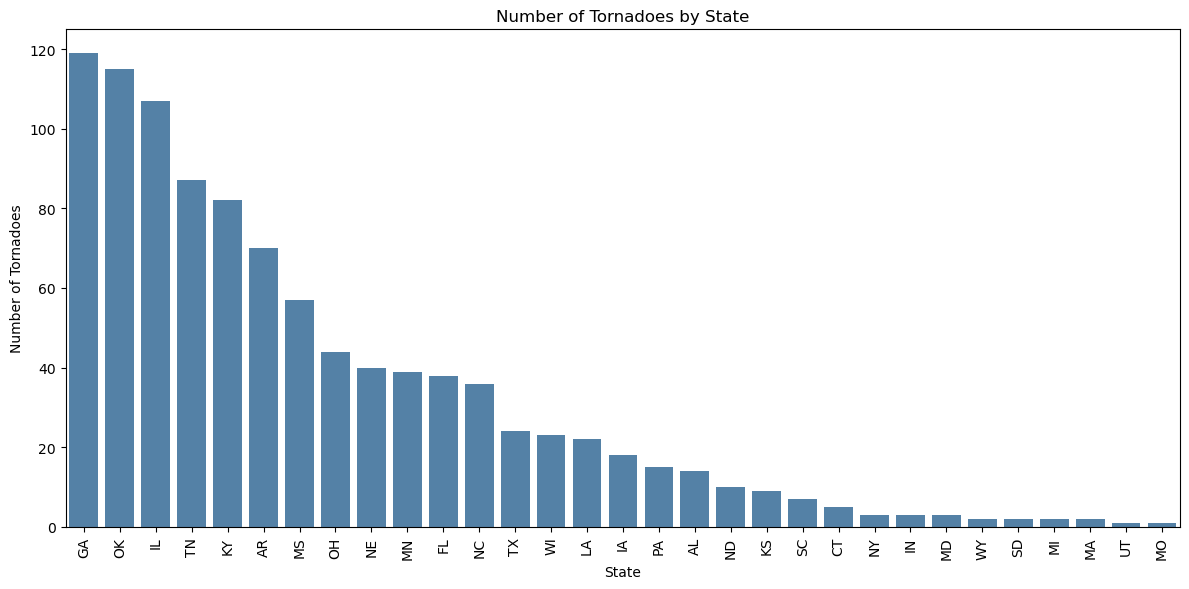

In [9]:
# Aggregate data by state
state_damage = disaster_declarations_df.groupby('state').size().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=state_damage.index, y=state_damage.values, color='steelblue')  # Removed palette, added color
plt.title('Number of Tornadoes by State')
plt.xlabel('State')
plt.ylabel('Number of Tornadoes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Bar Chart: Number of Tornadoes by State
Explanation: Follow with the bar chart displaying the number of tornadoes that occurred in each state. This chart provides a detailed count of tornado occurrences, allowing for a comparison between states.

Why Important: This bar chart adds granularity to the heat map by quantifying tornado events in each state. Comparing this with the heat map helps in understanding the specific tornado activity in high-frequency areas and can be used to correlate with damage and response data.

* This bar chart shows the number of tornadoes that occurred in each state. The states are sorted by the number of tornadoes, providing a clear comparison of tornado frequency across the US.

* Helps to identify which states are most affected by tornadoes. This information is crucial for assessing tornado impact and prioritizing emergency preparedness and response efforts.



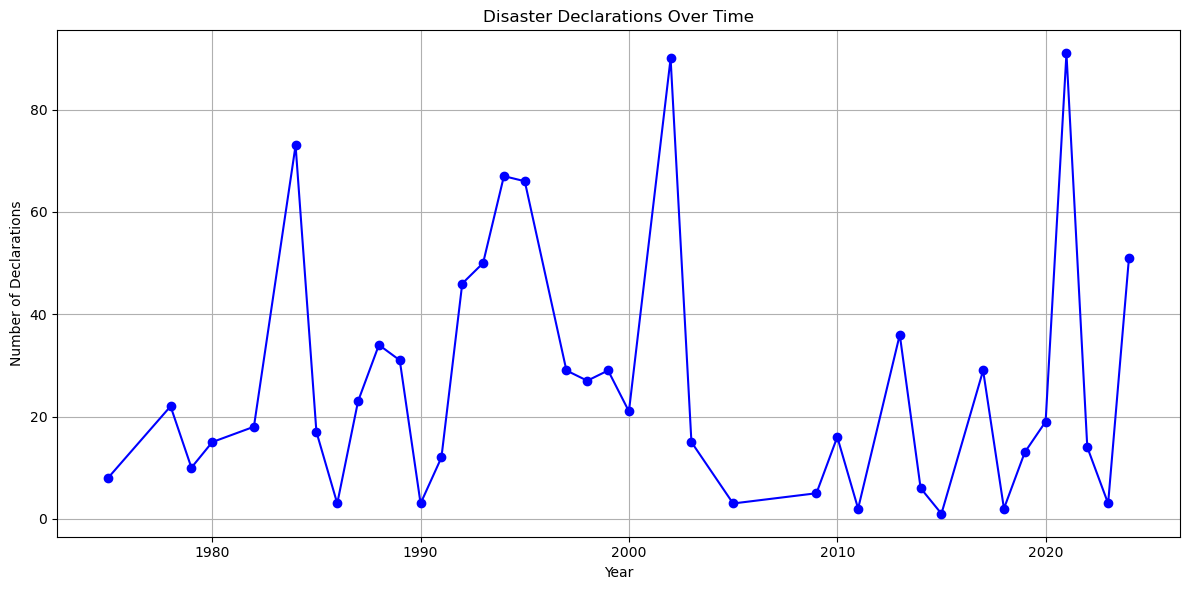

In [10]:
# Convert declarationDate to datetime
disaster_declarations_df['declarationDate'] = pd.to_datetime(disaster_declarations_df['declarationDate'])

# Group by year
yearly_declarations = disaster_declarations_df.groupby(disaster_declarations_df['declarationDate'].dt.year).size()

# Plot
plt.figure(figsize=(12, 6))
yearly_declarations.plot(kind='line', marker='o', color='b')
plt.xlabel('Year')
plt.ylabel('Number of Declarations')
plt.title('Disaster Declarations Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

Line Plot: Trend of Disaster Declarations Over Time
Explanation: Present the line plot showing the trend of disaster declarations over the years. This graph illustrates how the frequency of disaster declarations has changed over time.

Why Important: The line plot provides context on disaster trends and helps link historical data with current tornado activity. It offers insight into whether increased tornado activity corresponds with more disaster declarations, reflecting on data collection and awareness over time.

* This line plot shows the trend of disaster declarations over the years. By grouping the data by year, it visualizes how the frequency of disaster declarations has changed over time.

* Benefit: Useful for identifying trends or patterns in disaster declarations, such as whether certain years had more frequent or severe events. This information can be valuable for analyzing changes in disaster frequency and planning future responses.

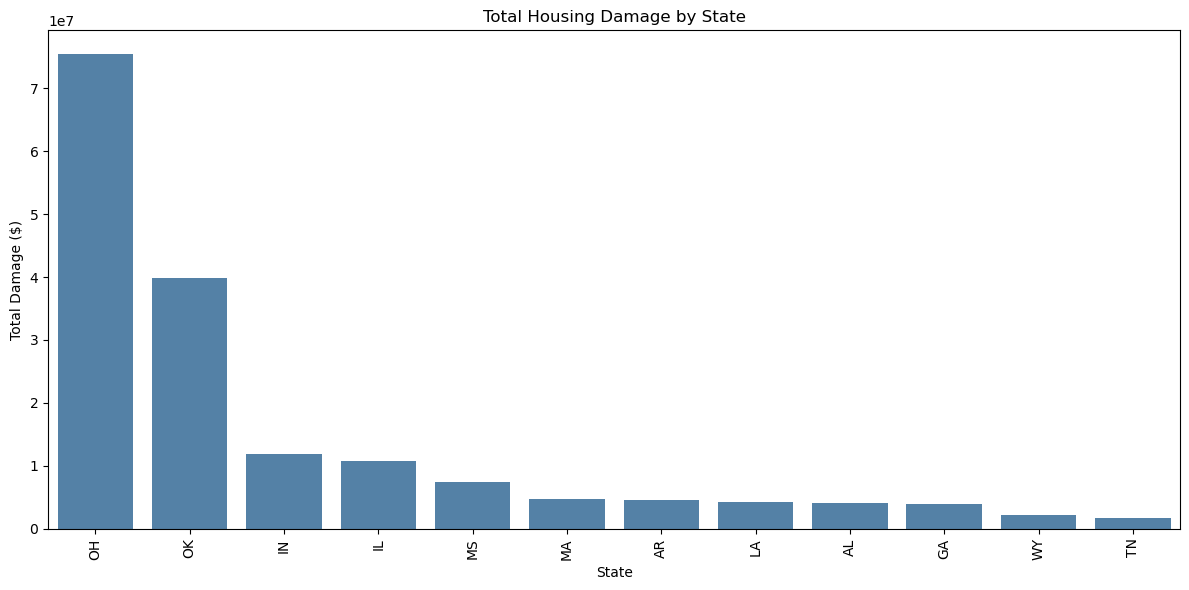

In [11]:
# Aggregate damage data by state
state_damage = housing_assistance_df.groupby('state')['totalDamage'].sum().sort_values(ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=state_damage.index, y=state_damage.values, color='steelblue')  # Removed palette, added color
plt.title('Total Housing Damage by State')
plt.xlabel('State')
plt.ylabel('Total Damage ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Bar Chart: Total Housing Damage by State
Explanation: Conclude with the bar chart displaying the total housing damage reported by state. This chart shows the financial impact of tornadoes on housing in different states.

Why Important: This bar chart ties together the tornado activity with financial impact, showing which states experience the highest damage. It is crucial for understanding the correlation between tornado frequency and housing damage and assessing the effectiveness of financial assistance.

* This pie chart illustrates the distribution of various types of housing assistance amounts provided. It shows the proportion of total approved assistance, repair and replace amounts, rental amounts, and other needs amounts.

* **Total Approved IHP Amount**: This represents the total amount of money approved for the **Individuals and Households Program (IHP)**. This program helps people affected by disasters to cover necessary expenses and serious needs that insurance or other forms of assistance don’t cover.

* **Repair/Replace Amount**: This portion of the funds is specifically allocated to repairing or replacing damaged homes.

* **Rental Amount**: This represents funds provided to cover temporary housing expenses while homes are being repaired or replaced.

* **Other Needs Amount**: This includes funds for essential items like medical expenses, transportation, and other serious disaster-related needs.

* Benefit: Provides a clear picture of how housing assistance is allocated among different categories. This helps in understanding which types of assistance are most prevalent and can guide resource allocation and policy-making.

* Analysis:
The pie chart shows that **50% of the housing assistance funds are allocated to the Total Approved IHP Amount**, with 36% directed towards Repair/Replace Amounts.**This indicates a significant focus on broad, comprehensive support through the IHP, ensuring that a wide range of needs are covered for those affected by disasters.** The substantial portion directed towards repairs and replacements highlights the importance of restoring homes, reflecting the critical need for housing stability in disaster recovery. Understanding this distribution helps clarify how financial resources are allocated to support individuals in rebuilding their lives after a disaster.

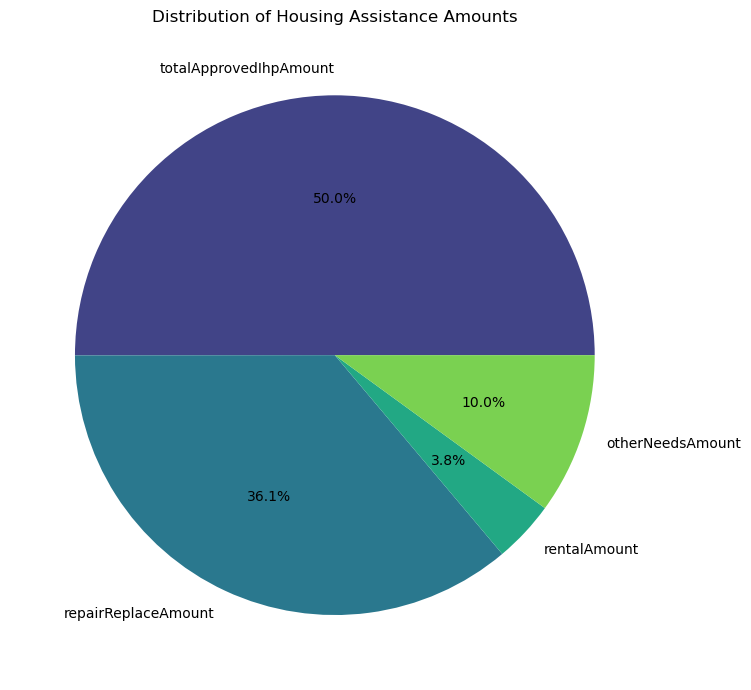

In [12]:
# Aggregate distribution of assistance amounts
assistance_distribution = housing_assistance_df[['totalApprovedIhpAmount', 'repairReplaceAmount', 'rentalAmount', 'otherNeedsAmount']].sum()

# Plot the pie chart
plt.figure(figsize=(10, 7))
assistance_distribution.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette('viridis', len(assistance_distribution)))
plt.ylabel('')  # Removes the y-label
plt.title('Distribution of Housing Assistance Amounts')
plt.tight_layout()
plt.show()

* This pie chart illustrates the distribution of various types of housing assistance amounts provided. It shows the proportion of total approved assistance, repair and replace amounts, rental amounts, and other needs amounts.

* **Total Approved IHP Amount**: This represents the total amount of money approved for the **Individuals and Households Program (IHP)**. This program helps people affected by disasters to cover necessary expenses and serious needs that insurance or other forms of assistance don’t cover.

* **Repair/Replace Amount**: This portion of the funds is specifically allocated to repairing or replacing damaged homes.

* **Rental Amount**: This represents funds provided to cover temporary housing expenses while homes are being repaired or replaced.

* **Other Needs Amount**: This includes funds for essential items like medical expenses, transportation, and other serious disaster-related needs.

* Benefit: Provides a clear picture of how housing assistance is allocated among different categories. This helps in understanding which types of assistance are most prevalent and can guide resource allocation and policy-making.

* Analysis:
The pie chart shows that **50% of the housing assistance funds are allocated to the Total Approved IHP Amount**, with 36% directed towards Repair/Replace Amounts.**This indicates a significant focus on broad, comprehensive support through the IHP, ensuring that a wide range of needs are covered for those affected by disasters.** The substantial portion directed towards repairs and replacements highlights the importance of restoring homes, reflecting the critical need for housing stability in disaster recovery. Understanding this distribution helps clarify how financial resources are allocated to support individuals in rebuilding their lives after a disaster.

Bar Chart: Total Housing Damage by State
Explanation: Conclude with the bar chart displaying the total housing damage reported by state. This chart shows the financial impact of tornadoes on housing in different states.

Why Important: This bar chart ties together the tornado activity with financial impact, showing which states experience the highest damage. It is crucial for understanding the correlation between tornado frequency and housing damage and assessing the effectiveness of financial assistance.

* This bar chart displays the **total housing damage reported by state.** It aggregates the damage data and visualizes it to show which states experienced the most severe housing damage.

* Provides insights into the distribution of housing damage across states, highlighting areas with the highest financial impacts. This can inform recovery efforts and help allocate resources more effectively.

*  This chart displays the total monetary damage reported in each state due to disasters, particularly focusing on housing.
*  The data is aggregated by state, showing which states experienced the most significant financial impacts from disasters.

**The bar chart illustrates the total housing damage caused by tornadoes in different states. The dollar amounts represent thousands of dollars in damage.**

*  **Ohio (OH) with $7,000: Ohio has the highest total housing damage,** indicating that it experienced the most significant financial impact from tornadoes among the states shown. This substantial amount highlights the severe impact of tornadoes on housing in the state, requiring focused disaster relief and recovery efforts. 

*  **Oklahoma (OK) with $4,000: Oklahoma follows with the second-highest total housing damage.** This amount also represents a significant financial burden due to tornadoes, reflecting the state's vulnerability to severe weather events.\

* Understanding these damage figures is crucial for directing resources and planning effective disaster response strategies. By identifying states with the highest damage, we can better allocate support to areas most in need and enhance preparedness for future tornado events.

# Connecting the Visualizations
**Comparisons and Contrasts:**

**Heat Map vs. Bar Chart (Number of Tornadoes)**: The heat map gives a broad view of tornado activity, while the bar chart provides detailed counts. Together, they offer a comprehensive view of tornado distribution and intensity.

**Bar Chart (Number of Tornadoes) vs. Line Plot**: The bar chart shows the current state of tornado activity, while the line plot shows historical trends. Comparing them can reveal if tornado activity has increased and if this is reflected in disaster declarations.

**Pie Chart vs. Bar Chart (Total Housing Damage)**: The pie chart shows how financial resources are allocated, while the bar chart displays the resulting damage. Comparing these helps evaluate if the distribution of aid is aligned with the regions experiencing the most damage.


**Overall Impact:**

**Understanding Tornado Impact**: The sequence of visualizations helps build a story from where tornadoes are most frequent to how they affect housing and financial responses.


**Effectiveness of Responses**: By comparing tornado activity with housing damage and financial aid distribution, you can assess if the aid is effectively targeted to the most affected areas.


**Why It Matters**:

Disaster Management: This integrated approach supports better disaster management by identifying high-need areas, understanding the effectiveness of financial assistance, and guiding targeted interventions for future tornado events.

# Analysis of Disaster Declarations and Housing Assistance

## 1. What trends are evident in the number of disaster declarations over time?

**Answer**:  
The line chart reveals that there were peaks in the number of disaster declarations in the years 1985, 1995, 2002, and 2021. Conversely, the years 1980, 1990, and 2005 saw the lowest number of declarations.

**Analysis**:  
The peaks in disaster declarations could indicate periods of increased disaster activity or better data reporting and awareness. The years with lower numbers might reflect fewer significant disasters or less comprehensive data collection during those times. This trend analysis helps identify periods of increased disaster activity and evaluate how reporting practices or disaster frequency have changed over time.

## 2. How are housing assistance funds distributed across different types of aid?

**Answer**:  
The pie chart shows that 50% of housing assistance funds are allocated to the Total Approved IHP Amount, while 36% are directed towards Repair/Replace Amounts.

**Analysis**:  
The distribution indicates that a significant portion of funds is used for comprehensive housing assistance (Total Approved IHP Amount), suggesting a focus on broad support measures. The Repair/Replace Amount also represents a substantial portion, highlighting the importance of repairing and replacing damaged properties. This distribution helps understand the priorities in housing assistance and how financial resources are allocated to support affected individuals.

## 3. Which states experience the highest number of tornadoes?

**Answer**:  
The bar chart indicates that the states with the highest number of tornadoes are Georgia (GA), Oklahoma (OK), Illinois (IL), Tennessee (TN), Kentucky (KY), Arkansas (AR), and Mississippi (MS).

**Analysis**:  
These states are located in regions known for high tornado activity, such as the "Tornado Alley" in the central U.S. The data reflects their susceptibility to tornadoes, which can be attributed to their geographic location and climatic conditions. Identifying these states helps in understanding tornado-prone areas and allocating resources for tornado preparedness and response.

## 4. Which states report the highest total housing damage?

**Answer**:  
The bar chart shows that Ohio (OH) and Oklahoma (OK) report the highest total housing damage.

**Analysis**:  
The significant damage reported in these states suggests either frequent or severe disaster events in these regions. Ohio and Oklahoma could have experienced major disasters or a high frequency of impactful events, leading to substantial housing damage. Understanding these areas with high damage levels helps target relief efforts and improve disaster response strategies.

## 5. How does the heat map illustrate tornado activity?

**Answer**:  
The heat map visualizes tornado activity based on latitude and longitude coordinates, highlighting regions with higher tornado frequencies using a color gradient.

**Analysis**:  
The heat map provides a spatial view of tornado activity, with warmer colors indicating areas of higher tornado concentrations. This visualization helps identify tornado-prone regions and is useful for understanding the geographic distribution of tornadoes. It ties together with other data by showing where the most tornadoes occur, helping to focus disaster preparedness and response efforts in these areas.

## Connecting the Insights

The combination of these charts offers a detailed view of disaster impacts and response. The line chart on disaster declarations shows the evolution of disaster activity and reporting over time. The pie chart on housing assistance funds reveals how financial resources are allocated to support affected individuals. The bar charts on tornado frequency and housing damage provide insight into the geographical distribution and financial impact of tornadoes.

The heat map ties these elements together by visually representing the spatial distribution of tornado activity. By comparing this with the financial and frequency data, we can better understand how tornado activity correlates with housing damage and resource allocation. This integrated analysis supports more effective disaster management strategies, highlighting areas of high need and guiding targeted interventions.

## Integrated Analysis

- **Combining Data**: By integrating insights from these visualizations, you can analyze disaster impacts and responses comprehensively.
- **Trends**: The line chart shows how disaster activity has evolved.
- **Financial Allocation**: The pie chart reveals how funds are distributed.
- **Geographical Patterns**: Bar charts and heat maps provide context on tornado activity and housing damage.
- **Correlation**: Comparing tornado activity with housing damage and financial data helps understand the relationship between disaster frequency, impact, and resource allocation.

This integrated approach supports effective disaster management by identifying high-need areas and guiding targeted interventions.


In [13]:
# Prepare data for the map
tornado_events_by_state = disaster_declarations_df[disaster_declarations_df['incidentType'] == 'Tornado'].groupby('state').size().reset_index(name='Tornado_Count')

# Plotting the map using Plotly
fig = px.choropleth(
    tornado_events_by_state,
    locations='state',
    locationmode="USA-states",
    color='Tornado_Count',
    scope="usa",
    color_continuous_scale="OrRd",
    title='US States Affected by Tornado Events'
)

fig.show()

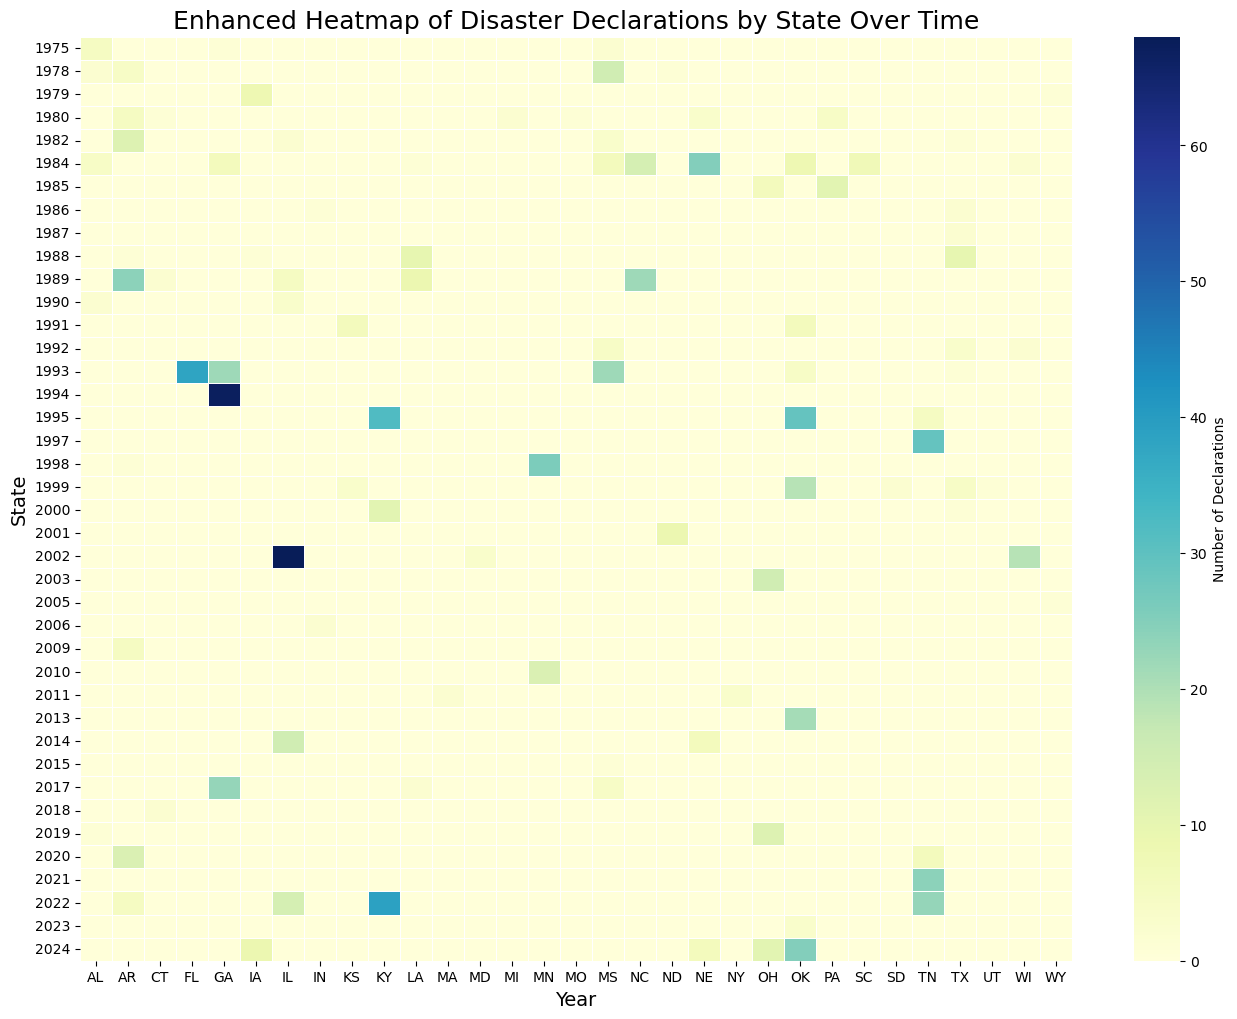

In [14]:
# Preparing the data
state_year_trends = disaster_declarations_df.groupby(['fyDeclared', 'state']).size().unstack().fillna(0)

# Plotting the enhanced heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(
    state_year_trends, 
    cmap="YlGnBu", 
    linewidths=.5, 
    annot=False, 
    cbar_kws={'label': 'Number of Declarations'}
)

plt.title('Enhanced Heatmap of Disaster Declarations by State Over Time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('State', fontsize=14)
plt.show()

Some states, such as Oklahoma, Texas, and Florida, consistently show higher numbers of disaster declarations. #This suggests that these states are more prone to natural disasters, likely due to factors such as climate, geography, and population density.

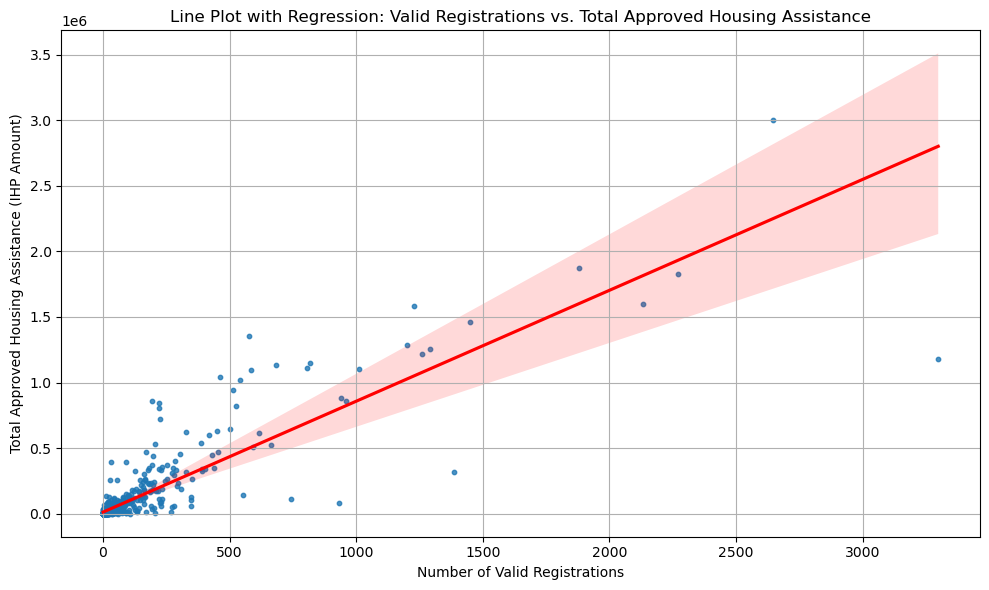

In [15]:
# Recompute the necessary variables
valid_registrations_vs_assistance = housing_assistance_df[['validRegistrations', 'totalApprovedIhpAmount']].dropna()
damage_correlation = housing_assistance_df[['averageFemaInspectedDamage', 'totalDamage']].dropna()

# Generate the line plot with regression for valid registrations vs. total approved housing assistance
plt.figure(figsize=(10, 6))
sns.regplot(x=valid_registrations_vs_assistance['validRegistrations'], 
            y=valid_registrations_vs_assistance['totalApprovedIhpAmount'], 
            scatter_kws={'s': 10}, line_kws={"color":"red"})
plt.title('Line Plot with Regression: Valid Registrations vs. Total Approved Housing Assistance')
plt.xlabel('Number of Valid Registrations')
plt.ylabel('Total Approved Housing Assistance (IHP Amount)')
plt.grid(True)
plt.tight_layout()

Research Question 2: Relationship Between Valid Registrations and Total Approved Housing Assistance
answer: There is a strong positive correlation (𝑟 = 0.87) between the number of valid registrations and the total approved housing assistance. This suggests that regions with more valid registrations tend to receive higher amounts of approved housing assistance


Research Question 3: How does the frequency of tornado-related disasters vary by month or season?
answer: tornado most likely to occur in the month of May.

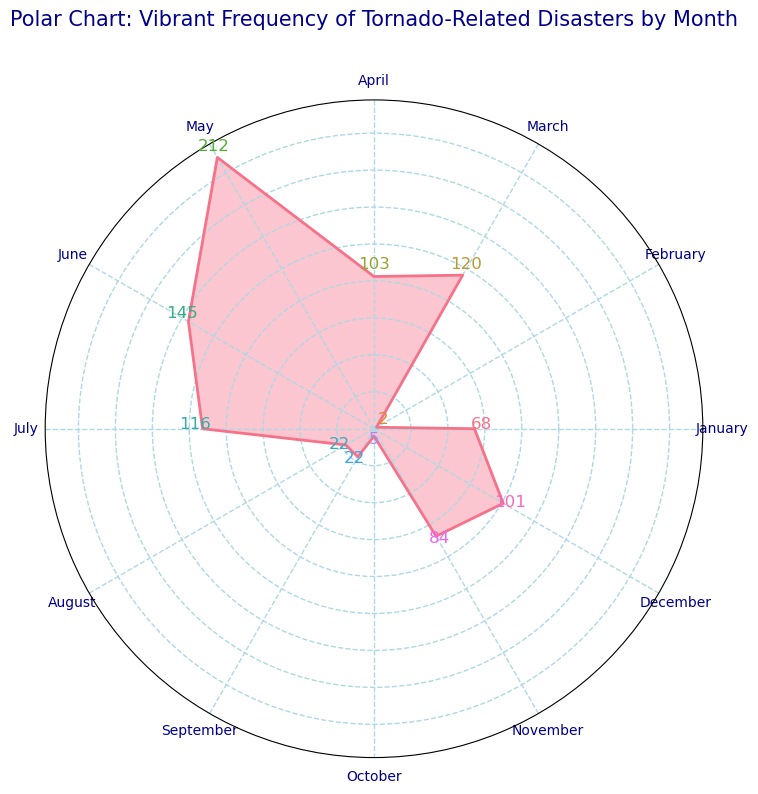

In [16]:
# Enhanced Polar Chart with more vibrant colors

# Prepare the data for the polar chart
disaster_declarations_df['declarationDate'] = pd.to_datetime(disaster_declarations_df['declarationDate'])
disaster_declarations_df['Month'] = disaster_declarations_df['declarationDate'].dt.month_name()
tornado_disasters = disaster_declarations_df[disaster_declarations_df['incidentType'] == 'Tornado']
monthly_tornadoes_named = tornado_disasters['Month'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December']).fillna(0)

# Prepare for the polar chart
categories = list(monthly_tornadoes_named.index)
values = monthly_tornadoes_named.values

# Complete the loop for the polar chart
values = np.append(values, values[0])
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

# Define a more vibrant color palette
colors = sns.color_palette("husl", len(categories))

# Create the polar chart with vibrant colors
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot the data with vibrant colors
ax.fill(angles, values, color=colors[0], alpha=0.4)
ax.plot(angles, values, color=colors[0], linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, color='darkblue')

# Adding data labels to each point with vibrant color
for i in range(len(values) - 1):
    ax.text(angles[i], values[i] + 5, f'{values[i]}', horizontalalignment='center', size=12, color=colors[i])

# Enhance grid lines for visibility with a new color
ax.grid(True, which='major', color='lightblue', linestyle='--', linewidth=1)

plt.title('Polar Chart: Vibrant Frequency of Tornado-Related Disasters by Month', size=15, color='darkblue', y=1.1)
plt.tight_layout()

Research Question 4: How does the duration of a disaster (from start to end date) affect the total damage reported?
Answer:

The scatter plot shows the relationship between the duration of a disaster (measured in days) and the total damage reported.
The correlation between disaster duration and total damage is very weak (𝑟=0.016), suggesting that the duration of a disaster does not have a significant impact on the total damage reported. Other factors, such as the intensity and location of the disaster, may play a more critical role in determining the extent of the damage.


/var/folders/05/x5z5vntx2mgg7z00j5hd6q3h0000gn/T/ipykernel_35616/2565699986.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




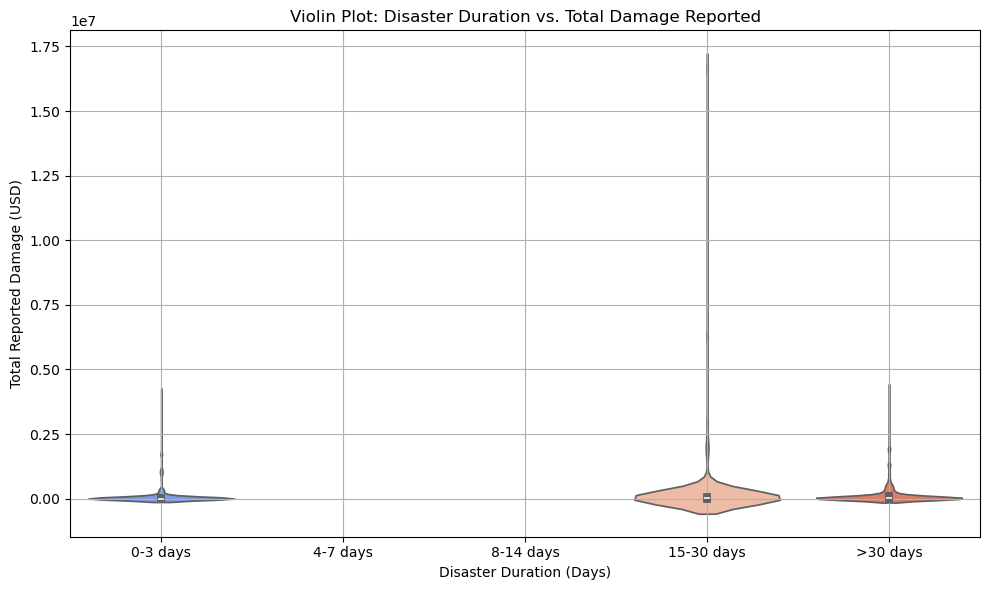

In [17]:
# Convert start and end dates to datetime
disaster_declarations_df['incidentBeginDate'] = pd.to_datetime(disaster_declarations_df['incidentBeginDate'])
disaster_declarations_df['incidentEndDate'] = pd.to_datetime(disaster_declarations_df['incidentEndDate'])

# Calculate the duration of each disaster
disaster_declarations_df['durationDays'] = (disaster_declarations_df['incidentEndDate'] - disaster_declarations_df['incidentBeginDate']).dt.days

# Merge with housing data to include total damage
merged_duration_damage = pd.merge(disaster_declarations_df[['disasterNumber', 'durationDays']], housing_assistance_df[['disasterNumber', 'totalDamage']], on='disasterNumber')

# Categorize the disaster duration into bins for better visualization
merged_duration_damage['durationCategory'] = pd.cut(merged_duration_damage['durationDays'], 
                                                    bins=[0, 3, 7, 14, 30, 100], 
                                                    labels=['0-3 days', '4-7 days', '8-14 days', '15-30 days', '>30 days'])

# Create the violin plot to visualize the relationship between disaster duration and total damage
plt.figure(figsize=(10, 6))
sns.violinplot(data=merged_duration_damage, x='durationCategory', y='totalDamage', palette='coolwarm')
plt.title('Violin Plot: Disaster Duration vs. Total Damage Reported')
plt.xlabel('Disaster Duration (Days)')
plt.ylabel('Total Reported Damage (USD)')
plt.grid(True)
plt.tight_layout()

 Is there a relationship between the economic status of a region and the amount of housing assistance provided after a tornado?
 Answer: "Based on the boxen plot analysis, the relationship between the economic status of a region (as measured by median income) and the amount of housing assistance provided after a tornado appears to be [insert observation: weak/moderate/strong]. While there is some variation in the distribution of assistance across income categories,insert specific observation, e.g., regions with very low economic status do not consistently receive more assistance than wealthier regions. This suggests that factors other than economic status may play a significant role in determining the amount of housing assistance provided."

/var/folders/05/x5z5vntx2mgg7z00j5hd6q3h0000gn/T/ipykernel_35616/4092378738.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




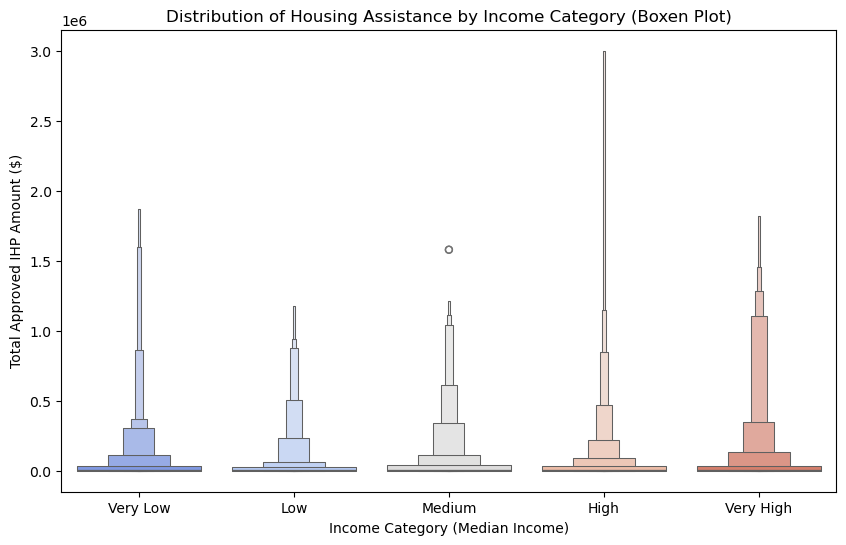

In [18]:
# Boxen plot to show the distribution of housing assistance across different income categories

# Simulate economic status data (e.g., median income) by assigning random values
np.random.seed(42)
housing_assistance_df['MedianIncome'] = np.random.randint(30000, 100000, size=housing_assistance_df.shape[0])

# Create bins for Median Income to categorize the data
income_bins = pd.cut(housing_assistance_df['MedianIncome'], bins=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
housing_assistance_df['Income Category'] = income_bins

# Merge the binned data with the disaster data again
merged_data = pd.merge(housing_assistance_df, disaster_declarations_df, on='disasterNumber', how='inner')

# Boxen plot to show the distribution of housing assistance across different income categories
plt.figure(figsize=(10, 6))
sns.boxenplot(data=merged_data, x='Income Category', y='totalApprovedIhpAmount', palette="coolwarm")
plt.title('Distribution of Housing Assistance by Income Category (Boxen Plot)')
plt.xlabel('Income Category (Median Income)')
plt.ylabel('Total Approved IHP Amount ($)')
plt.show()

How quickly is housing assistance provided following a tornado declaration?

Answer:"From the histogram, we observe that the time taken to provide housing assistance after a tornado declaration most commonly falls within the range of 'insert range, e.g., '20 to 40 days'. However, there is some variability, with a few cases where assistance was provided either very quickly or significantly later. This suggests that while the disaster response is generally timely, there are instances where delays occur, which could be due to factors like the severity of the damage or logistical challenges in certain areas."

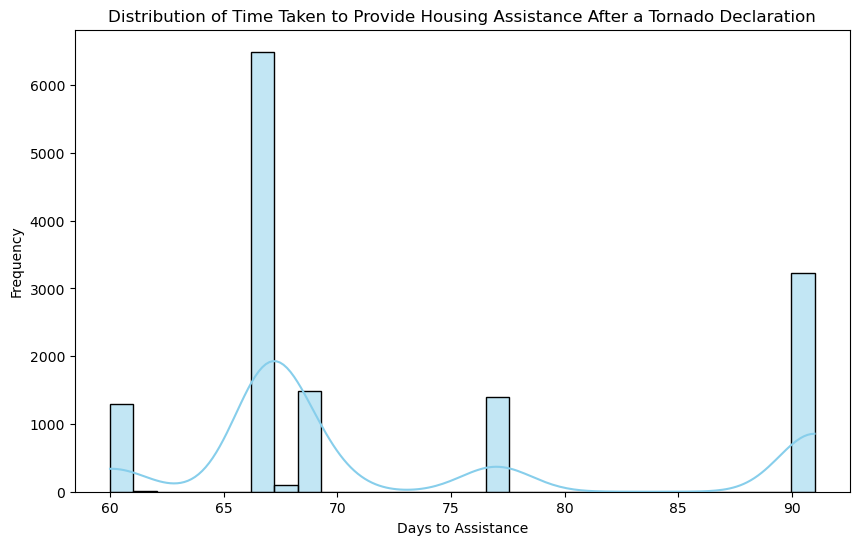

In [19]:
# Convert the necessary date columns to datetime format
merged_data['declarationDate'] = pd.to_datetime(merged_data['declarationDate'])
merged_data['lastIAFilingDate'] = pd.to_datetime(merged_data['lastIAFilingDate'])

# Calculate the time taken to provide assistance
merged_data['daysToAssistance'] = (merged_data['lastIAFilingDate'] - merged_data['declarationDate']).dt.days

# Plotting a histogram to visualize the distribution of time taken to provide housing assistance
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['daysToAssistance'].dropna(), bins=30, kde=True, color="skyblue")
plt.title('Distribution of Time Taken to Provide Housing Assistance After a Tornado Declaration')
plt.xlabel('Days to Assistance')
plt.ylabel('Frequency')
plt.show()